# <center> *mocalum* tutorial 5 <br><br> Monte-Carlo simulation for dual-Doppler configuration <center>

A notebook by Nikola Vasiljević
    
## Introduction

In tutorial we will peform Monte-Carlo simulations of dual-Doppler configuration uncertainty. We will consider two lidars whic are intersecting laser beams at a single point 100 m above ground level. Actually, this measurement point will have the same location as the center point of the PPI scan from `tutorial 4`. What we will vary in this tutorial is the between-beam angle (intersecting) of the two lidars as well the wind direction. If you are not familiar with `mocalum`, it is advisiable to go through the previous tutorials first.
    
If you want directly to explore earlier derives results of the Monte-Carlo simulations first import required libraries in the cell below and then go to the notebook section [Results of Monte Carlo simulations](#monte_carlo_results).

In [72]:
import numpy as np           
import matplotlib.pyplot as plt
import xarray as xr
import mocalum as mc

from tqdm.notebook import trange, tqdm

from mocalum_tutorial import plot_sd_scan_setup, plot_md_scan_setup, plot_bbox, plot_ffield, average_sonic

In [63]:
# setup of fontsize for plots

SMALL_SIZE = 12
MEDIUM_SIZE = 14
BIGGER_SIZE = 16

plt.rc('font', size=MEDIUM_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=MEDIUM_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=MEDIUM_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

In [64]:
mc_dd = mc.Mocalum()

## Initial lidar setup

Lets consider two lidars we will call 'koshava' and 'sterenn' which positions we will change only along `y` coordinate, starting with co-location at the position of (0,0,0). The measurement point will be set at (1000,0,100). The two lidars will have following values for uncertainty contributors (standard uncertainty):
- estimation uncertainty of radial velocity of 0.1 m/s 
- ranging uncertainty of 5 m
- azimuth uncertainty of 0.1 deg
- elevation uncertainty of 0.1 deg

Currently dual-Doppler configurations don't have feature of setting up correlated uncertainties among multiple lidars:

In [83]:
y_step = 100
pts = np.array([[1000,0,100]])

sim_wdir = [0,90]


unc_cfg = {'unc_az'   : 0.1,
           'unc_el'   : 0.1,
           'unc_rng'  : 5,
           'unc_est'  : 0.1,
           'corr_coef':0}

CT_cfg = {
    'points': pts,
    'no_scans' : 2*3*5*7*9*100,
    'acq_time' :1,
    'sync':True,
}


atmo_cfg={'wind_speed':10,
          'upward_velocity':0,
          'wind_from_direction': wind_from_direction,
          'reference_height':100, # we set the reference height same as the scanned height 
          'shear_exponent':0.2}

uncertainty = np.empty((len(range(0,10)),
                        len(sim_wdir),2))


b_angle = np.empty(10)
for i in trange(0,10, desc ="Lidar separation loop"):

    koshava_xyz = np.array([0,-i*y_step,0])
    sterenn_xyz = np.array([0,i*y_step,0])
    
    b_angle[i] =np.degrees(np.arcsin(i*y_step/1000))*2

    mc_dd.add_lidar('koshava', koshava_xyz, unc_cfg)
    mc_dd.add_lidar('sterenn', sterenn_xyz, unc_cfg)

    mc_dd.generate_complex_trajectory(['koshava', 'sterenn'],CT_cfg)    
    
    mc_dd.generate_uncertainties('koshava')
    mc_dd.generate_uncertainties('sterenn')
    
    
    for j, wind_from_direction in enumerate(tqdm(sim_wdir, desc ="Wind direction loop", leave = False)):

        atmo_cfg={'wind_speed':10,
                  'upward_velocity':0,
                  'wind_from_direction': wind_from_direction,
                  'reference_height':100, # we set the reference height same as the scanned height 
                  'shear_exponent':0.2}
        
        mc_dd.generate_flow_field(['koshava', 'sterenn'], atmo_cfg, 'turbulent')
        mc_dd.project_to_los('koshava')
        mc_dd.project_to_los('sterenn')


        # virtual sonic setup/generation
        time_steps = mc_dd.data.probing['koshava'].time.values
        mc_dd.generate_virtual_sonic(pts, time_steps)

        # average and reconstruct data
        mc_dd.reconstruct_wind(['koshava', 'sterenn'], 'dual-Doppler',600)
        avg_sonic_data = average_sonic(mc_IVAP.data.sonic_wind,600)    

        # calculate difference:
        diff_ds = avg_sonic_data - mc_dd.data.rc_wind

        # get standard uncertainty
        unc_ws = diff_ds.ws.std() # standard uncertainty of horizontal wind speed
        unc_dir = diff_ds.wdir.std() # standard uncertainty of wind direction    
        
        uncertainty[i,j,0] = unc_ws
        uncertainty[i,j,1] = unc_dir           

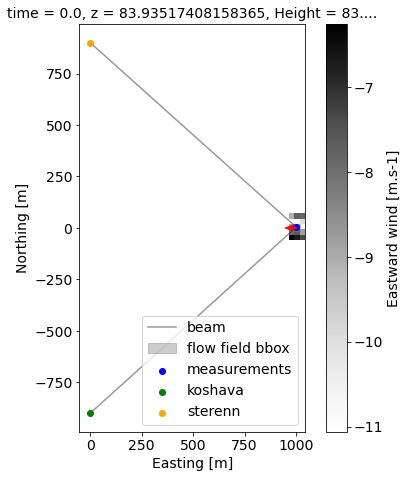

In [84]:
# Lets plot the last dual-Doppler setup and wind field:
plot_ffield(mc_dd)

In [86]:
ds_unc = xr.Dataset({'unc_ws': (['between_beam_angle', 'wind_direction'], uncertainty[:,:,0]),
                            'unc_wdir': (['between_beam_angle','wind_direction'], uncertainty[:,:,1])},
                           coords={'between_beam_angle': b_angle,
                                   'wind_direction': sim_wdir})

In [68]:
ds_unc.to_netcdf('./assets/DD_uncertainty.nc')

<a id='monte_carlo_results'></a>
# Results of Monte Carlo simulations

You can either analyze/plot your own results or you can directly load results from the previous Monte Carlo simulations which are located in the subdirectory `assets`. If you decide to load the results from the previous simulation execture the cell below, otherwise simply skip it and continue to the next cell after it.

In [69]:
ds_unc = xr.open_dataset('./assets/DD_uncertainty.nc')

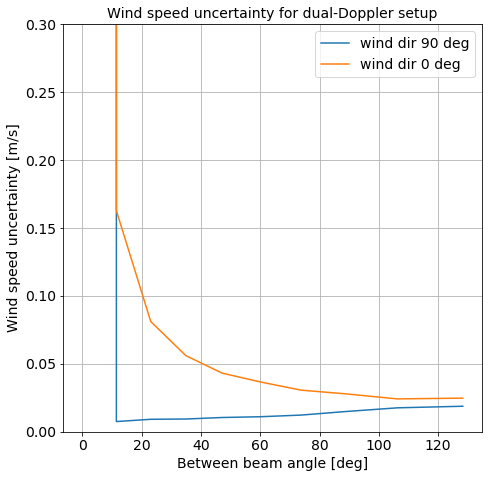

In [91]:
fig, ax = plt.subplots(figsize=(7.5, 7.5))
plt.grid()


ds_unc.unc_ws.sel(wind_direction=90).plot(ax=ax, label='wind dir 90 deg')
ds_unc.unc_ws.sel(wind_direction=0).plot(ax=ax, label='wind dir 0 deg')
plt.ylim(0,0.3)

plt.xlabel('Between beam angle [deg]')
plt.ylabel('Wind speed uncertainty [m/s]')
plt.title('Wind speed uncertainty for dual-Doppler setup')

plt.legend(loc="upper right")
plt.show()

fig.savefig('./assets/wind_speed_uncertainty_dual-Doppler.png')